# Yield optimisation

- This is an example notebook how to optimise yield across multiple ERC-4626 vaults.
- The strategy rebalances between several ERC-4626 vaults on Base blockchains based on rolling returns.
- This example uses a vault sample dataset provided with [Trading Strategy](https://github.com/tradingstrategy-ai/trading-strategy/) Python package.


# Set up

Set up Trading Strategy data client.


In [1]:
import logging

from tradingstrategy.client import Client
from tradeexecutor.utils.notebook import setup_charting_and_output, OutputMode, set_notebook_logging

client = Client.create_jupyter_client()

# Set up drawing charts in interactive vector output mode.
# This is slower. See the alternative commented option below.
# setup_charting_and_output(OutputMode.interactive)

# Set up rendering static PNG images.
# This is much faster but disables zoom on any chart.
setup_charting_and_output(OutputMode.static, image_format="png", width=1500, height=1000)


logger = logging.getLogger("strategy")



Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/moo/.tradingstrategy


# Parameters

- Collection of parameters used in the calculations

In [2]:
import datetime

import pandas as pd

from tradingstrategy.chain import ChainId
from tradingstrategy.timebucket import TimeBucket
from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.strategy.parameters import StrategyParameters
from tradeexecutor.strategy.default_routing_options import TradeRouting


# List of vaults we rebalance.
# If we enable Gains market making vault we need to adjust the signal,
# because otherwise the strategy will take losses on the vault.
VAULTS = [
    (ChainId.base, "0x45aa96f0b3188d47a1dafdbefce1db6b37f58216"),  # Ipor Base
    # (ChainId.base, "0xad20523a7dc37babc1cc74897e4977232b3d02e5"),  # Gains Network
    (ChainId.base, "0xcddcdd18a16ed441f6cb10c3909e5e7ec2b9e8f3"),  # Apostro Resolv USDC
    (ChainId.base, "0xc0c5689e6f4d256e861f65465b691aeecc0deb12"),  # Gauntled USDC core
    (ChainId.base, "0xb99b6df96d4d5448cc0a5b3e0ef7896df9507cf5"),  # 40 acres
    # https://summer.fi/earn/base/position/0x98c49e13bf99d7cad8069faa2a370933ec9ecf17
    (ChainId.base, "0x98c49e13bf99d7cad8069faa2a370933ec9ecf17"),  # Summer.fi lazy vault
    # https://app.morpho.org/base/vault/0x50b5b81Fc8B1f1873Ec7F31B0E98186ba008814D/indefi-usdc
    (ChainId.base, "0x50b5b81fc8b1f1873ec7f31b0e98186ba008814d"),  # InDefi USDc on Morpho
]



class Parameters:
    id = "yield-optimisation"
    candle_time_bucket = TimeBucket.d1
    cycle_duration = CycleDuration.cycle_1d
    chain_id = ChainId.base

    # Backtest duration
    backtest_start = datetime.datetime(2025, 1, 1)
    backtest_end = datetime.datetime(2025, 5, 10)
    initial_cash = 100_000

    # Signal parameters
    rolling_returns_bars = 7

    # Basket parameters
    allocation = 0.99  # Remaining % always in cash
    min_portfolio_weight = 0.005  # Don't open too small positions
    max_assets_in_portfolio = 5  # N vaults at a time
    max_concentration = 0.75  # Max % of portfolio per vault
    per_position_cap_of_pool = 0.03  # 1% of the vault TVL
    assummed_liquidity_when_data_missings = 0.0  # In data gaps, assume
    individual_rebalance_min_threshold_usd = 150.00
    sell_rebalance_min_threshold = 5.0

    

parameters = StrategyParameters.from_class(Parameters)  # Convert to AttributedDict to easier typing with dot notation

# Trading pairs and market data

- This creates the strategy universe containing pair metadata and their prices
- The universe is "masked" by simply selecting pairs on the predefined pairs list

In [3]:
from tradingstrategy.client import Client
from tradingstrategy.pair import PandasPairUniverse
from tradingstrategy.client import Client
from tradingstrategy.client import Client
from tradingstrategy.candle import GroupedCandleUniverse
from tradingstrategy.client import Client
from tradingstrategy.exchange import ExchangeUniverse
from tradingstrategy.liquidity import GroupedLiquidityUniverse
from tradingstrategy.pair import PandasPairUniverse
from tradingstrategy.timebucket import TimeBucket
from tradingstrategy.universe import Universe
from tradingstrategy.alternative_data.vault import load_multiple_vaults, load_vault_price_data, convert_vault_prices_to_candles


from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse, translate_token
from tradeexecutor.strategy.execution_context import ExecutionContext, notebook_execution_context
from tradeexecutor.strategy.universe_model import UniverseOptions
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradeexecutor.strategy.execution_context import ExecutionContext, notebook_execution_context
from tradeexecutor.strategy.universe_model import UniverseOptions
from tradeexecutor.analysis.pair import display_strategy_universe



def create_trading_universe(
    timestamp: datetime.datetime,
    client: Client,
    execution_context: ExecutionContext,
    universe_options: UniverseOptions,
) -> TradingStrategyUniverse:
    """Create a trading universe with named vaults on Base."""
    chain_id = Parameters.chain_id
    time_bucket = Parameters.candle_time_bucket

    exchanges, pairs_df = load_multiple_vaults(VAULTS)
    vault_prices_df = load_vault_price_data(pairs_df)

    # Create pair universe based on the vault data
    exchange_universe = ExchangeUniverse({e.exchange_id: e for e in exchanges})
    pair_universe = PandasPairUniverse(pairs_df, exchange_universe=exchange_universe)

    # Create price candles from vault share price scrape
    candle_df, liquidity_df = convert_vault_prices_to_candles(vault_prices_df, "1d")
    candle_universe = GroupedCandleUniverse(candle_df, time_bucket=TimeBucket.h1)
    liquidity_universe = GroupedLiquidityUniverse(liquidity_df, time_bucket=Parameters.candle_time_bucket)

    data_universe = Universe(
        time_bucket=time_bucket,
        chains={chain_id},
        exchange_universe=exchange_universe,
        pairs=pair_universe,
        candles=candle_universe,
        liquidity=liquidity_universe,
    )

    usdc_token = pair_universe.get_token("0x833589fCD6eDb6E08f4c7C32D4f71b54bdA02913".lower(), chain_id)
    assert usdc_token is not None
    usdc = translate_token(usdc_token)

    strategy_universe = TradingStrategyUniverse(
        data_universe=data_universe,
        reserve_assets=[usdc],
    )

    return strategy_universe


strategy_universe = create_trading_universe(
    None,
    client,
    notebook_execution_context,
    UniverseOptions.from_strategy_parameters_class(Parameters, notebook_execution_context)
)

print("Universe creation done")

display_strategy_universe(
    strategy_universe, 
    sort_key="tvl",
    sort_numeric=True,
    sort_ascending=False,
    limit=20,
)


Universe creation done
Results limited to first 20 entries


base quote                          exchange  fee %  \
id                                                                       
278843159        LVUSDC  USDC          LazyVault_LowerRisk_USDC    0.0   
269347602       gtUSDCc  USDC                Gauntlet USDC Core    0.0   
273710325         VAULT  USDC                             Vault    0.0   
284525078  ipUSDCfusion  USDC  IPOR USDC Lending Optimizer Base    0.0   
280619251       aprUSDC  USDC               Apostro Resolv USDC    0.0   
268992845      indeUSDC  USDC                       IndeFi USDC    0.0   

             type    price last_price_at first_price_at  volume        tvl  \
id                                                                           
278843159  traded     1.01        7 days     2025-02-10       0  7,555,350   
269347602  traded     1.04        7 days     2024-06-17       0  5,441,969   
273710325  traded  1691.70        7 days     2025-01-30       0  1,846,222   
284525078  traded     1.04        7 days     2024-11-13       0  1,347,039   
280619251  traded     1.01        7 days     2025-02-21       0    634,597   
268992845  traded     1.02        7 days     2025-02-21       0    232,680   

          tvl_at   pfee  mfee    tax  
id                                    
278843159 7 days    NaN   NaN  - / -  
269347602 7 days  10.0%  0.0%  - / -  
273710325 7 days    NaN   NaN  - / -  
284525078 7 days  10.0%  1.0%  - / -  
280619251 7 days  10.0%  0.0%  - / -  
268992845 7 days  10.0%  0.0%  - / -

### Asset to trading pair map

- Build a helper map
- Because we are operating on trading pairs, not on tokens, which are the base asset of a trading pair, we set up 
  this map to easily look up the selected trading pair by its symbol

In [4]:
from tradingstrategy.types import TokenSymbol
from tradeexecutor.state.identifier import TradingPairIdentifier

# Create base token symbol to pair map to help later
# Token
token_map: dict[TokenSymbol, TradingPairIdentifier] = {p.base.token_symbol: p for p in strategy_universe.iterate_pairs()}

# Tokens part of benchmark data, but not the strategy
benchmark_pair_ids = [p.internal_id for p in strategy_universe.iterate_pairs() if p.other_data.get("benchmark") is True]
category_pair_ids = [p.internal_id for p in strategy_universe.iterate_pairs() if p.other_data.get("benchmark") is not True]

print(f"Token map is {len(token_map)} assets")
print("Category trading pairs", len(category_pair_ids))
print("Benchmark trading pairs", len(benchmark_pair_ids))

Token map is 6 assets
Category trading pairs 6
Benchmark trading pairs 0


# Indicators

- Precalculate indicators used by the strategy

In [5]:
import pandas as pd
from IPython.display import HTML
import pandas_ta

from tradeexecutor.strategy.pandas_trader.indicator import IndicatorSource
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradeexecutor.strategy.pandas_trader.indicator import calculate_and_load_indicators_inline
from tradeexecutor.strategy.pandas_trader.indicator import IndicatorDependencyResolver
from tradeexecutor.state.types import USDollarAmount
from tradeexecutor.strategy.pandas_trader.indicator_decorator import IndicatorRegistry
from tradeexecutor.analysis.indicator import display_indicators
from tradingstrategy.utils.groupeduniverse import resample_candles


indicators = IndicatorRegistry()

empty_series = pd.Series([], index=pd.DatetimeIndex([]))


# Calculate cleaned rolling returns
@indicators.define()
def rolling_returns(close: pd.Series, rolling_returns_bars: int) -> pd.Series:    
    """"Calculate rolling returns for a given number of bars."""
    returns = close.pct_change()
    cumulative_rolling_returns = (1 + returns).rolling(window=rolling_returns_bars).apply(lambda x: x.prod() - 1)
    return cumulative_rolling_returns


@indicators.define(source=IndicatorSource.tvl)
def tvl(
    close: pd.Series,
    execution_context: ExecutionContext,
    timestamp: pd.Timestamp,
) -> pd.Series:
    if execution_context.live_trading:
        # TVL is daily data.
        # We need to forward fill until the current hour.
        # Use our special ff function.
        assert isinstance(timestamp, pd.Timestamp), f"Live trading needs forward-fill end time, we got {timestamp}"
        from tradingstrategy.utils.forward_fill import forward_fill
        df = pd.DataFrame({"close": close})
        df_ff = forward_fill(
            df,
            Parameters.candle_time_bucket.to_frequency(),
            columns=("close",),
            forward_fill_until=timestamp,
        )
        series = df_ff["close"]
        return series
    else:
        return close


@indicators.define(
    dependencies=(rolling_returns,),
    source=IndicatorSource.dependencies_only_per_pair
)
def signal(
    rolling_returns_bars: int,
    dependency_resolver: IndicatorDependencyResolver,
    pair: TradingPairIdentifier,
) -> pd.Series:
    """Momentum signal: signal = 7 days returns"""
    series = dependency_resolver.get_indicator_data(
        name=rolling_returns,
        parameters={
            "rolling_returns_bars": rolling_returns_bars,
        },
        pair=pair,
    )
    return series
     


display_indicators(indicators)

# Calculate all indicators where parameters have changed and store the result on disk
indicator_data = calculate_and_load_indicators_inline(
    strategy_universe=strategy_universe,
    create_indicators=indicators.create_indicators,
    parameters=parameters,
    max_workers=1,
)


total = len(indicator_data.indicator_results)
print(f"Loaded total {total} indicator data series across all pairs")

We have 3 indicators:
Using indicator cache /Users/moo/.cache/indicators/base_1d_6_2025-02-21-2025-05-07
Loaded total 18 indicator data series across all pairs


## Price vs. rolling returns

- Plot our signal to see if it makes sense

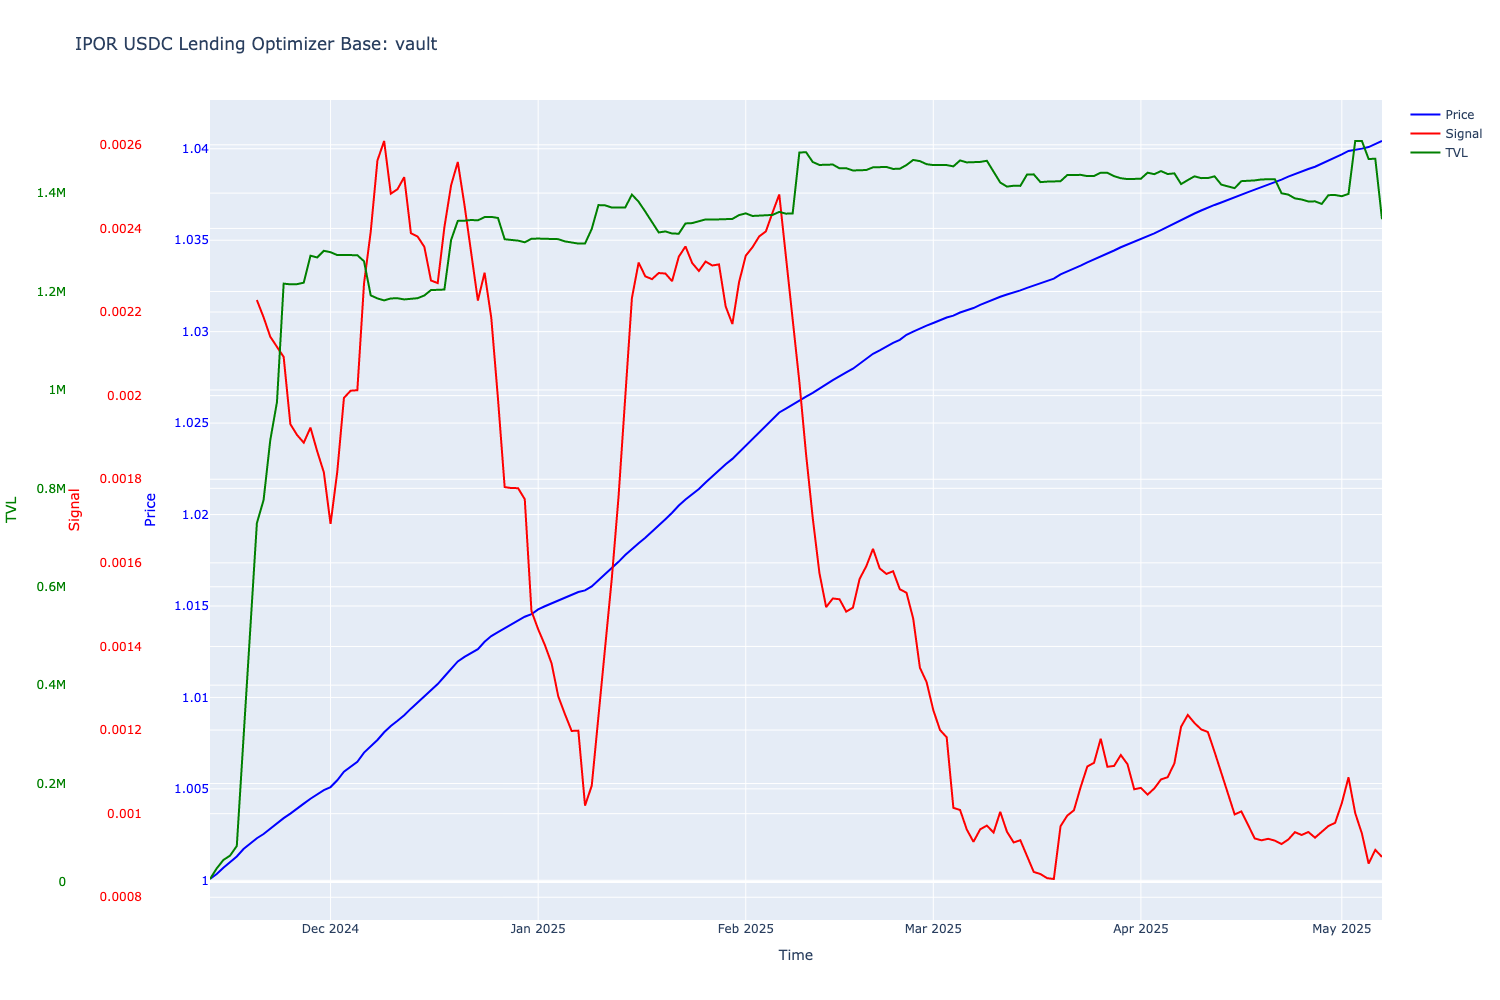

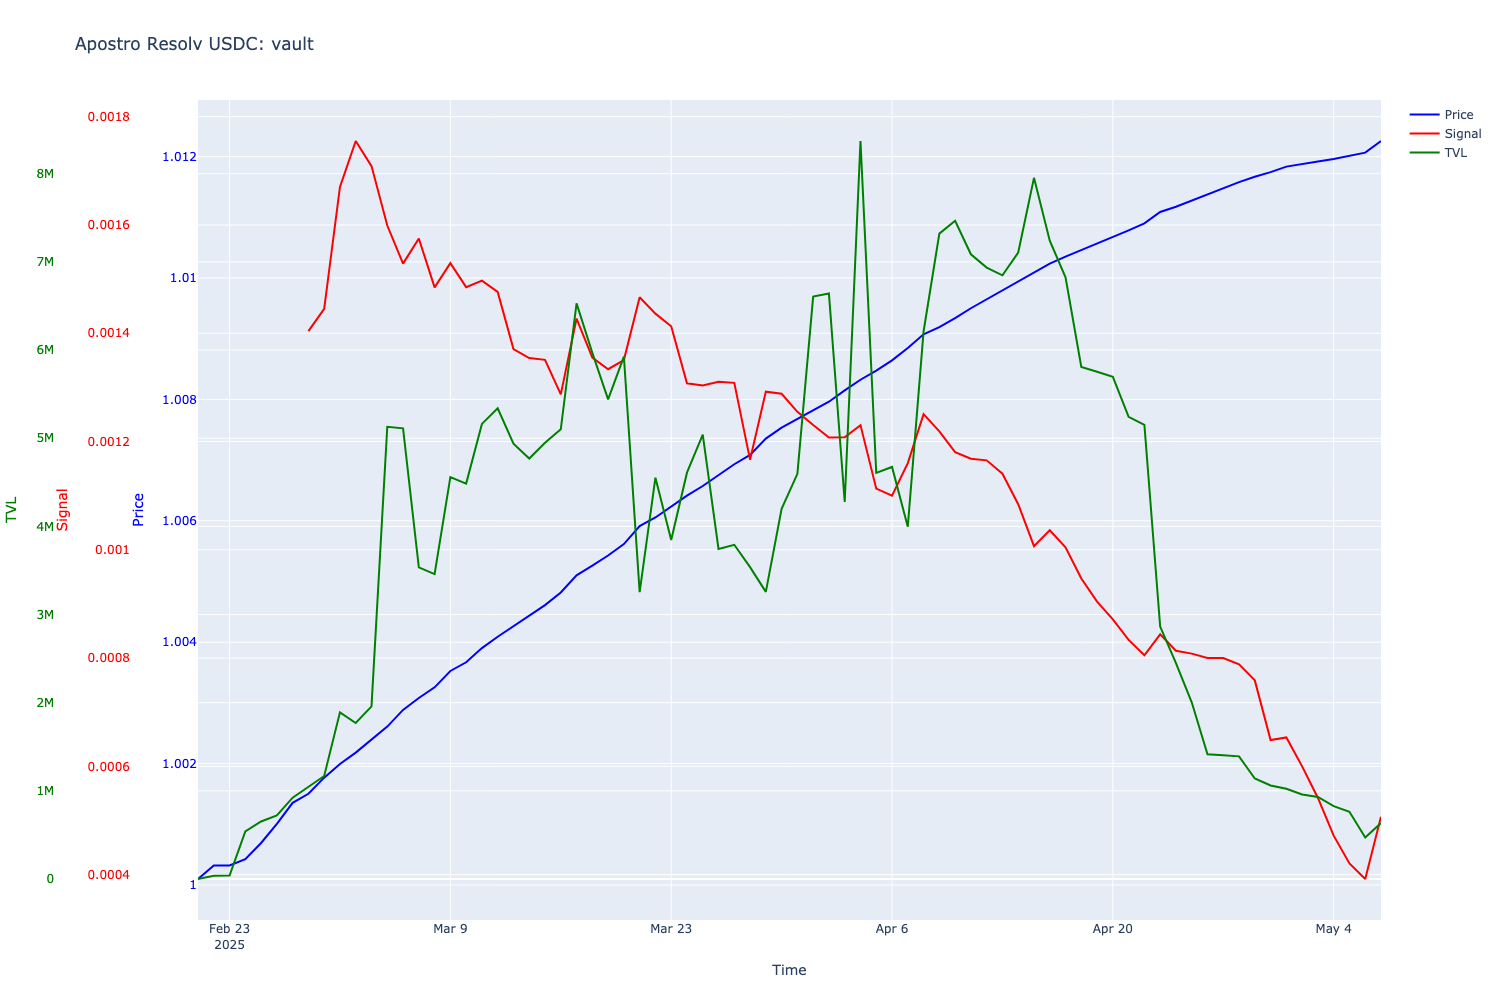

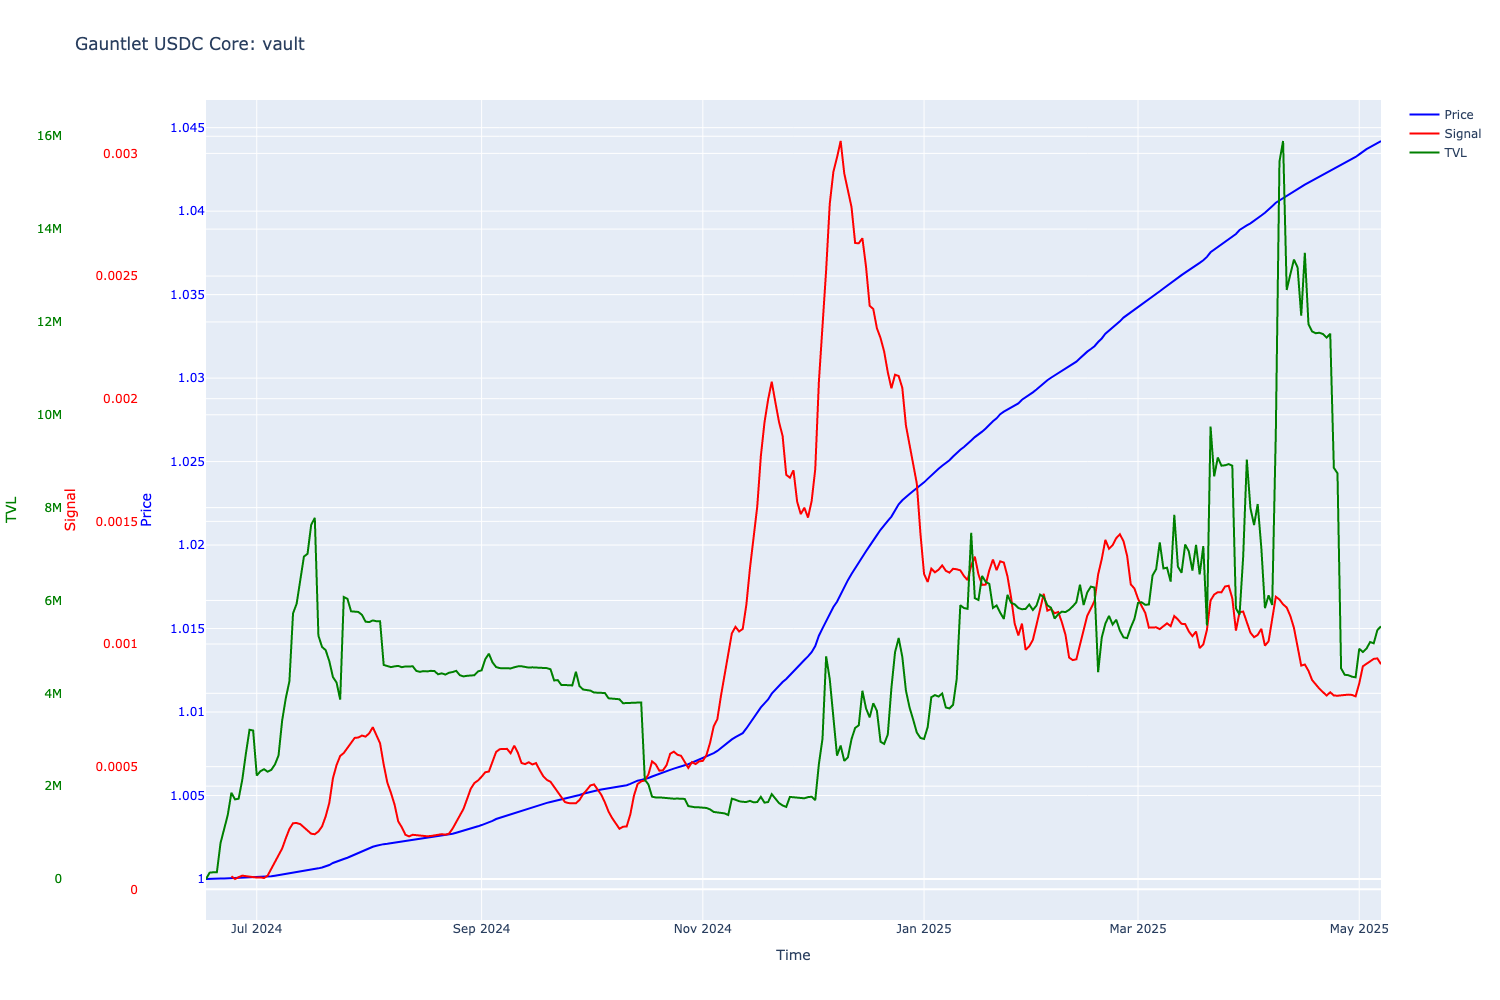

price    signal           tvl
timestamp                                   
2025-05-03  1.043714  0.000919  4.962922e+06
2025-05-04  1.043841  0.000931  5.104707e+06
2025-05-05  1.043966  0.000939  5.077800e+06
2025-05-06  1.044084  0.000941  5.362877e+06
2025-05-07  1.044201  0.000918  5.441969e+06

In [6]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

selected_assets = VAULTS[0:3]

# TODO: Plotly refuses correctly to plot the third y-axis
for chain, address in selected_assets:
    pair = strategy_universe.get_pair_by_address(address)
    name = pair.get_vault_name()
    price = strategy_universe.data_universe.candles.get_candles_by_pair(pair.internal_id)["close"]
    signal = indicator_data.get_indicator_series("signal", pair=pair)  
    tvl = indicator_data.get_indicator_series("tvl", pair=pair)

    
    df = pd.DataFrame({
        "price": price,
        "signal": signal,
        "tvl": tvl
    })

    fig = go.Figure()

    # Do three y-axes
    # Add traces for each y-axis
    colors = ["blue", "red", "green"]
    fig.add_trace(go.Scatter(x=df.index, y=df.price, name="Price", yaxis="y1", line=dict(color=colors[0])))
    fig.add_trace(go.Scatter(x=df.index, y=df.signal, name="Signal", yaxis="y2", line=dict(color=colors[1])))
    fig.add_trace(go.Scatter(x=df.index, y=df.tvl, name="TVL", yaxis="y3", line=dict(color=colors[2])))

    # Update layout settings
    fig.update_layout(
        xaxis=dict(title="Time"),  # Set x-axis title
        yaxis1=dict(title="Price", titlefont=dict(color=colors[0]), tickfont=dict(color=colors[0]) ),  # Set y-axis title for the first trace
        yaxis2=dict(title="Signal", anchor="free", overlaying="y", autoshift=True, titlefont=dict(color=colors[1]), tickfont=dict(color=colors[1])),  # Second y-axis settings
        yaxis3=dict(title="TVL", anchor="free", overlaying="y", autoshift=True, titlefont=dict(color=colors[2]), tickfont=dict(color=colors[2])),  # Third y-axis settings
        title_text=f"{name}: vault",  # Set graph title
        width=900
    )

    fig.show()


display(df.tail(5))
    

# Backtest time range

- Choose the backtesting time range
- Start when we have enough assets (`Parameters.min_asset_universe`) in our asset universe to form the first basket

In [7]:
# Get the first date where the condition is True
backtest_start = Parameters.backtest_start
backtest_end = Parameters.backtest_end

print(f"Time range is {backtest_start} - {backtest_end}")

Time range is 2025-01-01 00:00:00 - 2025-05-10 00:00:00


# Strategy algorithm and backtest

- Run the backtest

In [8]:
from tradeexecutor.backtest.backtest_runner import run_backtest_inline
from tradeexecutor.strategy.alpha_model import AlphaModel
from tradeexecutor.state.trade import TradeExecution
from tradeexecutor.strategy.pandas_trader.strategy_input import StrategyInput, IndicatorDataNotFoundWithinDataTolerance
from tradeexecutor.state.visualisation import PlotKind
from tradeexecutor.backtest.backtest_runner import run_backtest_inline
from tradeexecutor.strategy.tvl_size_risk import USDTVLSizeRiskModel
from tradeexecutor.strategy.weighting import weight_by_1_slash_n, weight_passthrouh, weight_equal
from tradeexecutor.utils.dedent import dedent_any


def decide_trades(
    input: StrategyInput
) -> list[TradeExecution]:
    """For each strategy tick, generate the list of trades."""
    parameters = input.parameters
    position_manager = input.get_position_manager()
    state = input.state
    timestamp = input.timestamp
    indicators = input.indicators
    strategy_universe = input.strategy_universe

    portfolio = state.portfolio
    assert portfolio.get_total_equity() > 0
    assert portfolio.get_position_equity_and_loan_nav() >= 0

    # Set up alpha model
    alpha_model = AlphaModel(
        timestamp,
        close_position_weight_epsilon=parameters.min_portfolio_weight,  # 10 BPS is our min portfolio weight
    )

    # Generate new weights
    for pair in strategy_universe.iterate_pairs():
        weight = indicators.get_indicator_value("signal", pair=pair)
        if weight is None or weight <= 0:
            # The vault does not yet exist in this timestamp,
            # or has negative rolling returns
            continue
        alpha_model.set_signal(
            pair,
            weight,
        )

    portfolio_target_value = portfolio.get_total_equity() * parameters.allocation

    alpha_model.select_top_signals(count=parameters.max_assets_in_portfolio)
    alpha_model.assign_weights(method=weight_passthrouh)

    alpha_model.update_old_weights(
        state.portfolio,
        ignore_credit=False,
    )

    size_risk_model = USDTVLSizeRiskModel(
        pricing_model=input.pricing_model,
        per_position_cap=parameters.per_position_cap_of_pool,  # This is how much % by all pool TVL we can allocate for a position
        missing_tvl_placeholder_usd=parameters.assummed_liquidity_when_data_missings,  # Placeholder for missing TVL data until we get the data off the chain
    )

    alpha_model.normalise_weights(
        investable_equity=portfolio_target_value,
        size_risk_model=size_risk_model,
        max_weight=parameters.max_concentration,
    )
    alpha_model.calculate_target_positions(position_manager)

    trades = alpha_model.generate_rebalance_trades_and_triggers(
        position_manager,
        min_trade_threshold=parameters.individual_rebalance_min_threshold_usd,
        invidiual_rebalance_min_threshold=parameters.individual_rebalance_min_threshold_usd,
        sell_rebalance_min_threshold=parameters.sell_rebalance_min_threshold,
        execution_context=input.execution_context,
    )

    try:
        position_manager.check_enough_cash(trades)
    except Exception as e:
        # Dump alpha model
        raise RuntimeError(f"Alpha model flow calculations failed: {alpha_model.get_debug_print()}") from e
    
    if input.is_visualisation_enabled():
        state.visualisation.set_discardable_data("alpha_model", alpha_model)

    return trades


result = run_backtest_inline(
    name=parameters.id,
    engine_version="0.5",
    decide_trades=decide_trades,
    create_indicators=indicators.create_indicators,
    client=client,
    universe=strategy_universe,
    parameters=parameters,
    # log_level=logging.INFO,
    max_workers=1,
    start_at=backtest_start,
    end_at=backtest_end,
)

state = result.state

trade_count = len(list(state.portfolio.get_all_trades()))
print(f"Backtesting completed, backtested strategy made {trade_count} trades")

Reading cached indicators rolling_returns, tvl, signal for 6 pairs, using 10 threads:   0%|          | 0/18 [0…

Using indicator cache /Users/moo/.cache/indicators/base_1d_6_2025-02-21-2025-05-07


  0%|          | 0/11145600 [00:00<?, ?it/s]

Backtesting completed, backtested strategy made 388 trades


# Performance metrics

- Display portfolio performance metrics
- Compare against buy and hold matic using the same initial capital

**Note**: Some of these metrics might be incorrect due to slow start of the strategy

In [9]:
from tradeexecutor.analysis.multi_asset_benchmark import compare_strategy_backtest_to_multiple_assets

interesting_assets = [
    strategy_universe.get_pair_by_address(VAULTS[0][1]).base.token_symbol,
    strategy_universe.get_pair_by_address(VAULTS[1][1]).base.token_symbol, 
    strategy_universe.get_pair_by_address(VAULTS[2][1]).base.token_symbol, 
]

compare_strategy_backtest_to_multiple_assets(
    state,
    strategy_universe,
    display=True,
    interesting_assets=interesting_assets,
    asset_count=3,
)

Strategy         ipUSDCfusion  \
Start Period                        2025-01-01           2025-01-01   
End Period                          2025-05-09           2025-05-09   
Risk-Free Rate                            0.0%                 0.0%   
Time in Market                           98.0%                98.0%   
Cumulative Return                        2.73%                2.52%   
CAGR﹪                                    5.44%                5.03%   
Sharpe                                   51.97                42.56   
Prob. Sharpe Ratio                      100.0%                    -   
Smart Sharpe                             22.97                18.81   
Sortino                                      -                    -   
Smart Sortino                                -                    -   
Sortino/√2                                   -                    -   
Smart Sortino/√2                             -                    -   
Omega                                        -                    -   
Max Drawdown                                 %                    %   
Longest DD Days                              -                    -   
Volatility (ann.)                        0.15%                0.17%   
Calmar                                       -                    -   
Skew                                      0.51                 0.57   
Kurtosis                                  2.14                -0.25   
Expected Daily                           0.02%                0.02%   
Expected Monthly                         0.54%                 0.5%   
Expected Yearly                          2.73%                2.52%   
Kelly Criterion                              -                    -   
Risk of Ruin                              0.0%                 0.0%   
Daily Value-at-Risk                     -0.01%               -0.01%   
Expected Shortfall (cVaR)               -0.01%               -0.01%   
Max Consecutive Wins                       126                  126   
Max Consecutive Losses                       0                    0   
Gain/Pain Ratio                              -                    -   
Gain/Pain (1M)                               -                    -   
Payoff Ratio                                 -                    -   
Profit Factor                                -                    -   
Common Sense Ratio                           -                    -   
CPC Index                                    -                    -   
Tail Ratio                                3.59                  4.0   
Outlier Win Ratio                         1.87                 1.97   
Outlier Loss Ratio                           -                    -   
MTD                                      0.28%                0.09%   
3M                                       1.97%                 1.4%   
6M                                       2.73%                2.52%   
YTD                                      2.73%                2.52%   
1Y                                       2.73%                2.52%   
3Y (ann.)                                5.44%                5.03%   
5Y (ann.)                                5.44%                5.03%   
10Y (ann.)                               5.44%                5.03%   
All-time (ann.)                          5.44%                5.03%   
Best Day                                 0.05%                0.04%   
Worst Day                                 0.0%                 0.0%   
Best Month                               0.75%                0.85%   
Worst Month                              0.28%                0.09%   
Best Year                                2.73%                2.52%   
Worst Year                               2.73%                2.52%   
Recovery Factor                              -                    -   
Ulcer Index                                0.0                  0.0   
Serenity Index                               -                

# Equity curve

- Equity curve shows how your strategy accrues value over time

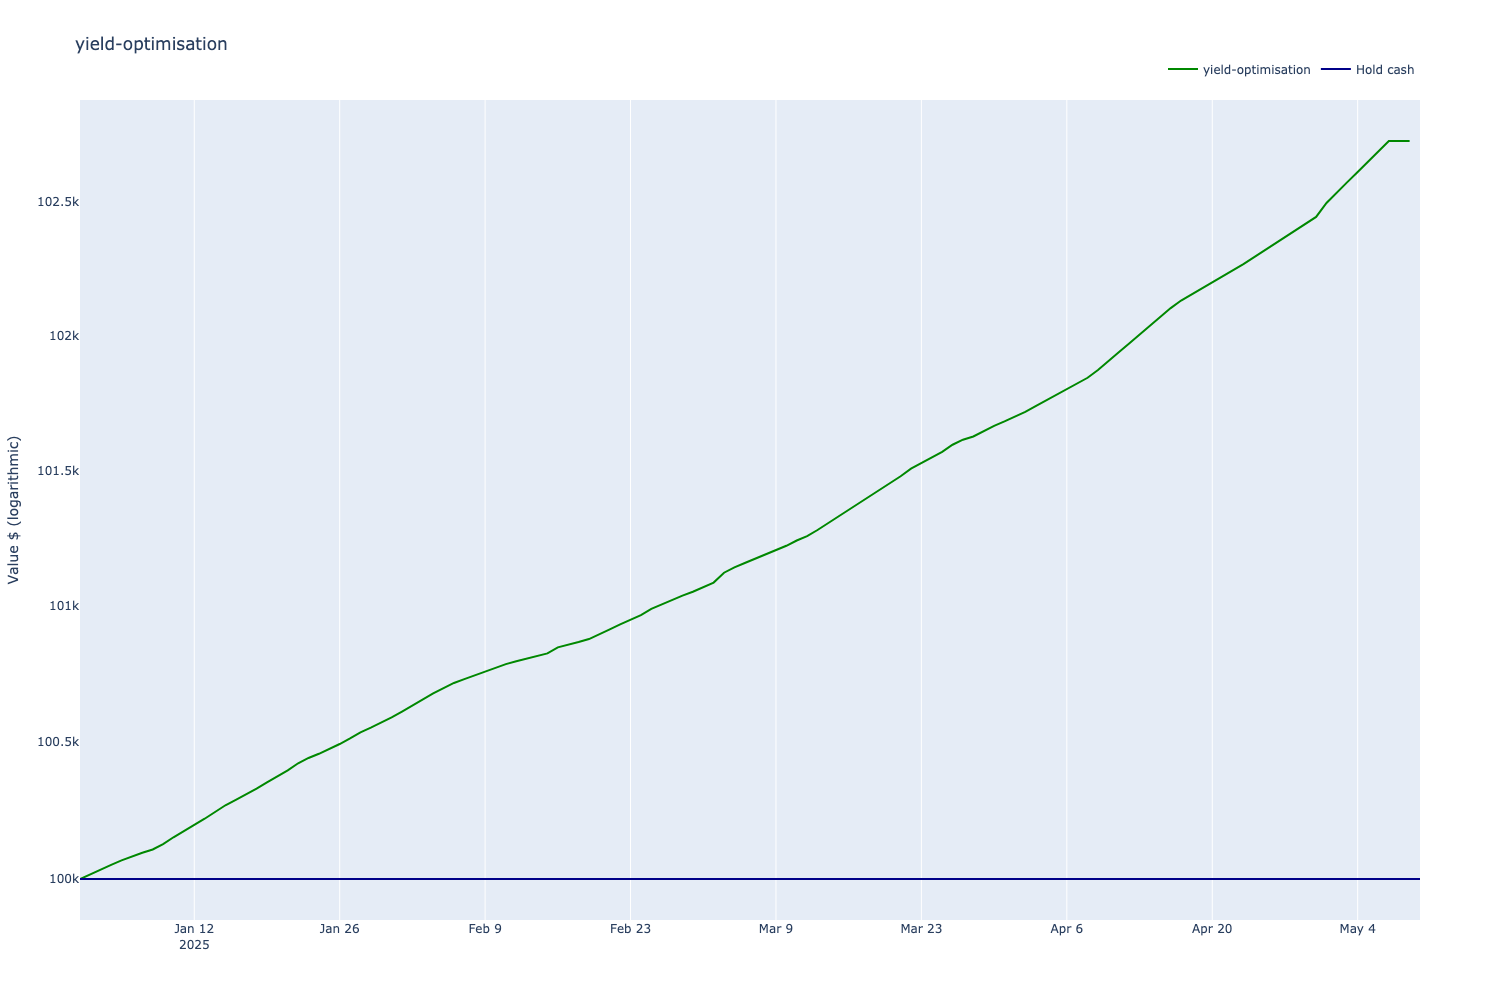

In [10]:
import pandas as pd
from tradeexecutor.analysis.multi_asset_benchmark import get_benchmark_data
from tradeexecutor.visual.benchmark import visualise_equity_curve_benchmark

benchmark_indexes = get_benchmark_data(
    strategy_universe,
    cumulative_with_initial_cash=state.portfolio.get_initial_cash(),
    max_count=4,
    start_at=state.get_trading_time_range()[0],
)

fig = visualise_equity_curve_benchmark(
    state=state,    
    benchmark_indexes=benchmark_indexes,
    height=800,
    log_y=True,
)

fig.show()

## Equity curve with drawdown

- Linear curve

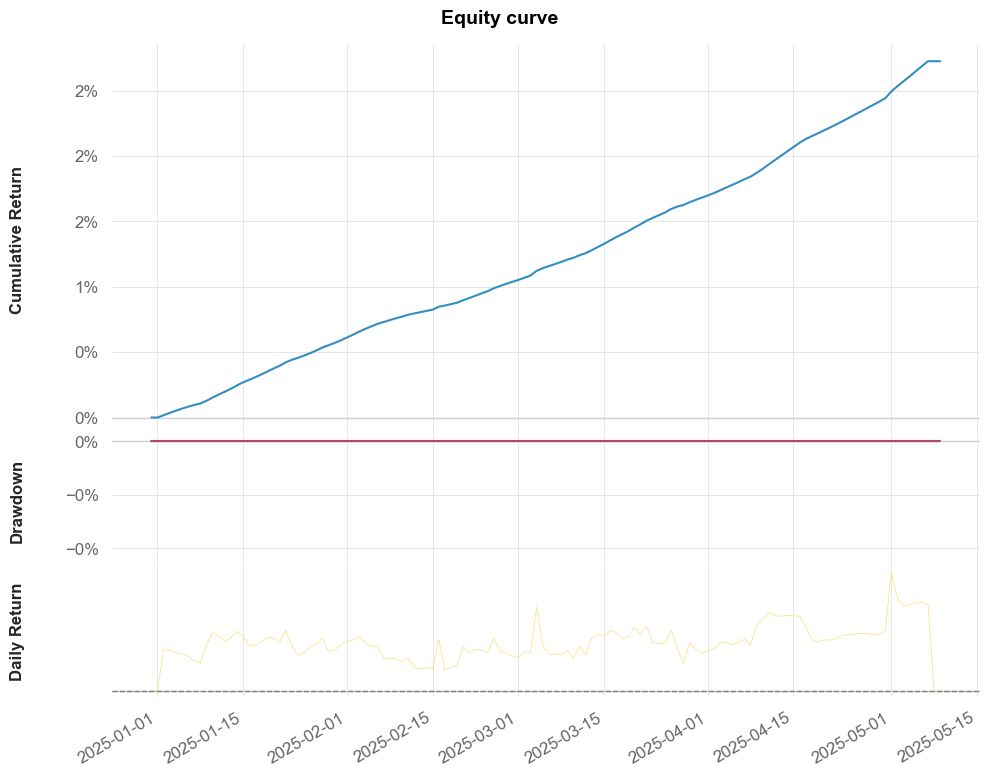

In [11]:
from tradeexecutor.visual.equity_curve import calculate_equity_curve, calculate_returns
from tradeexecutor.visual.equity_curve import visualise_equity_curve

curve = calculate_equity_curve(state)
returns = calculate_returns(curve)
fig = visualise_equity_curve(returns)
display(fig)

# Asset weights

- What assets were allocated over time
- Do both proportional % and USD weights

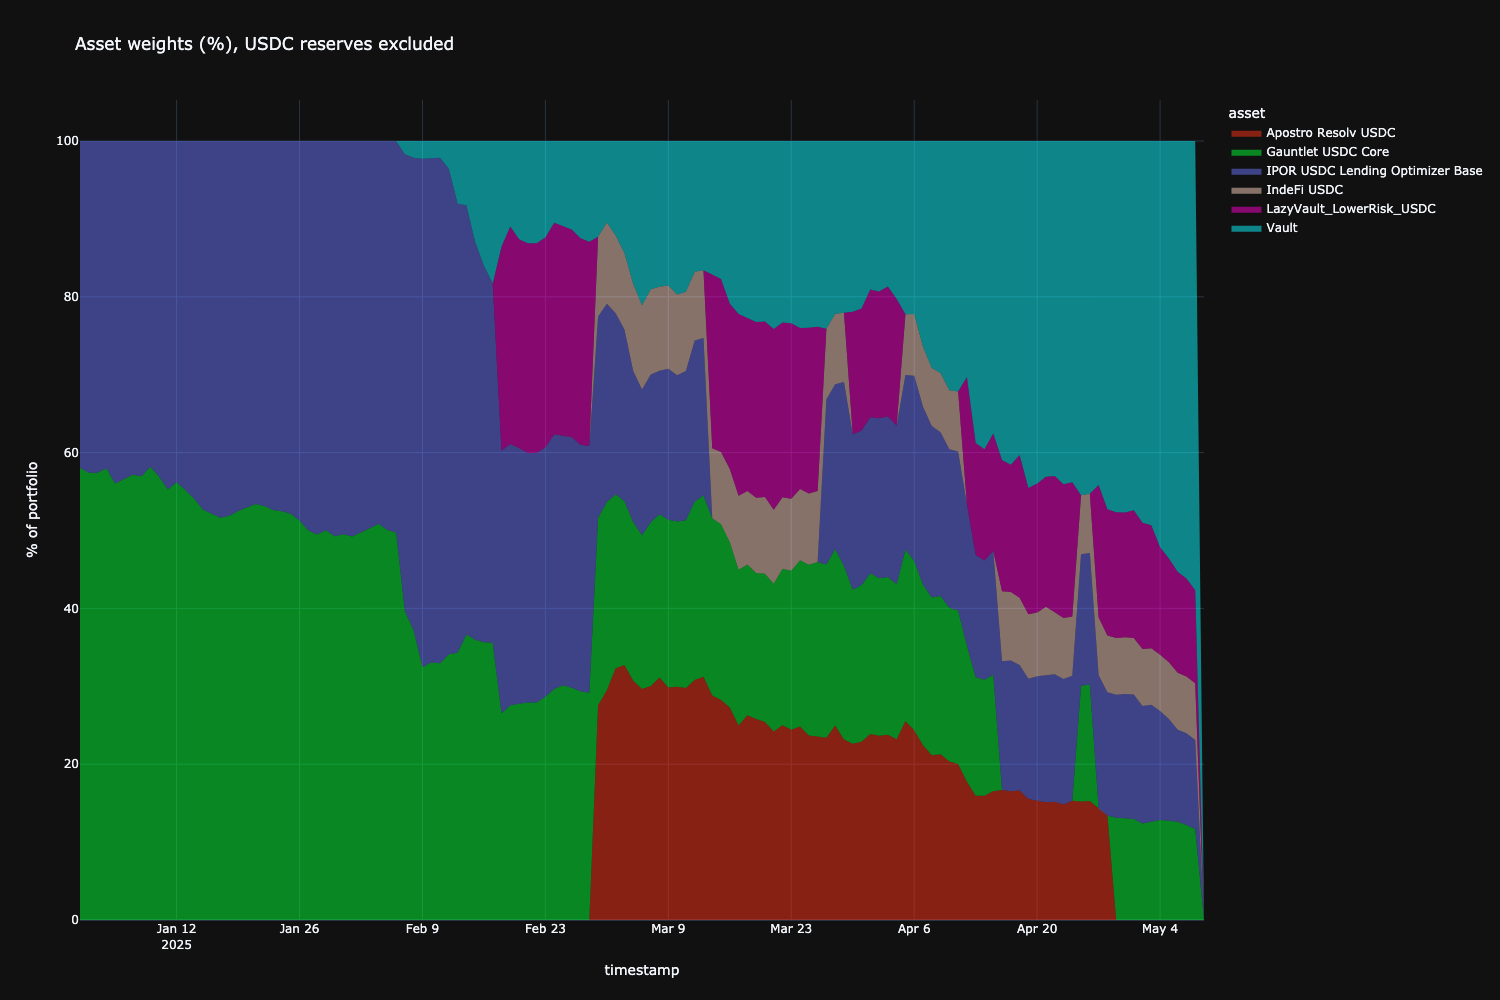

In [12]:
from tradeexecutor.analysis.weights import calculate_asset_weights, visualise_weights

weights_series = calculate_asset_weights(state)

fig = visualise_weights(
    weights_series,
    normalised=True,
    include_reserves=False,
)
fig.show()

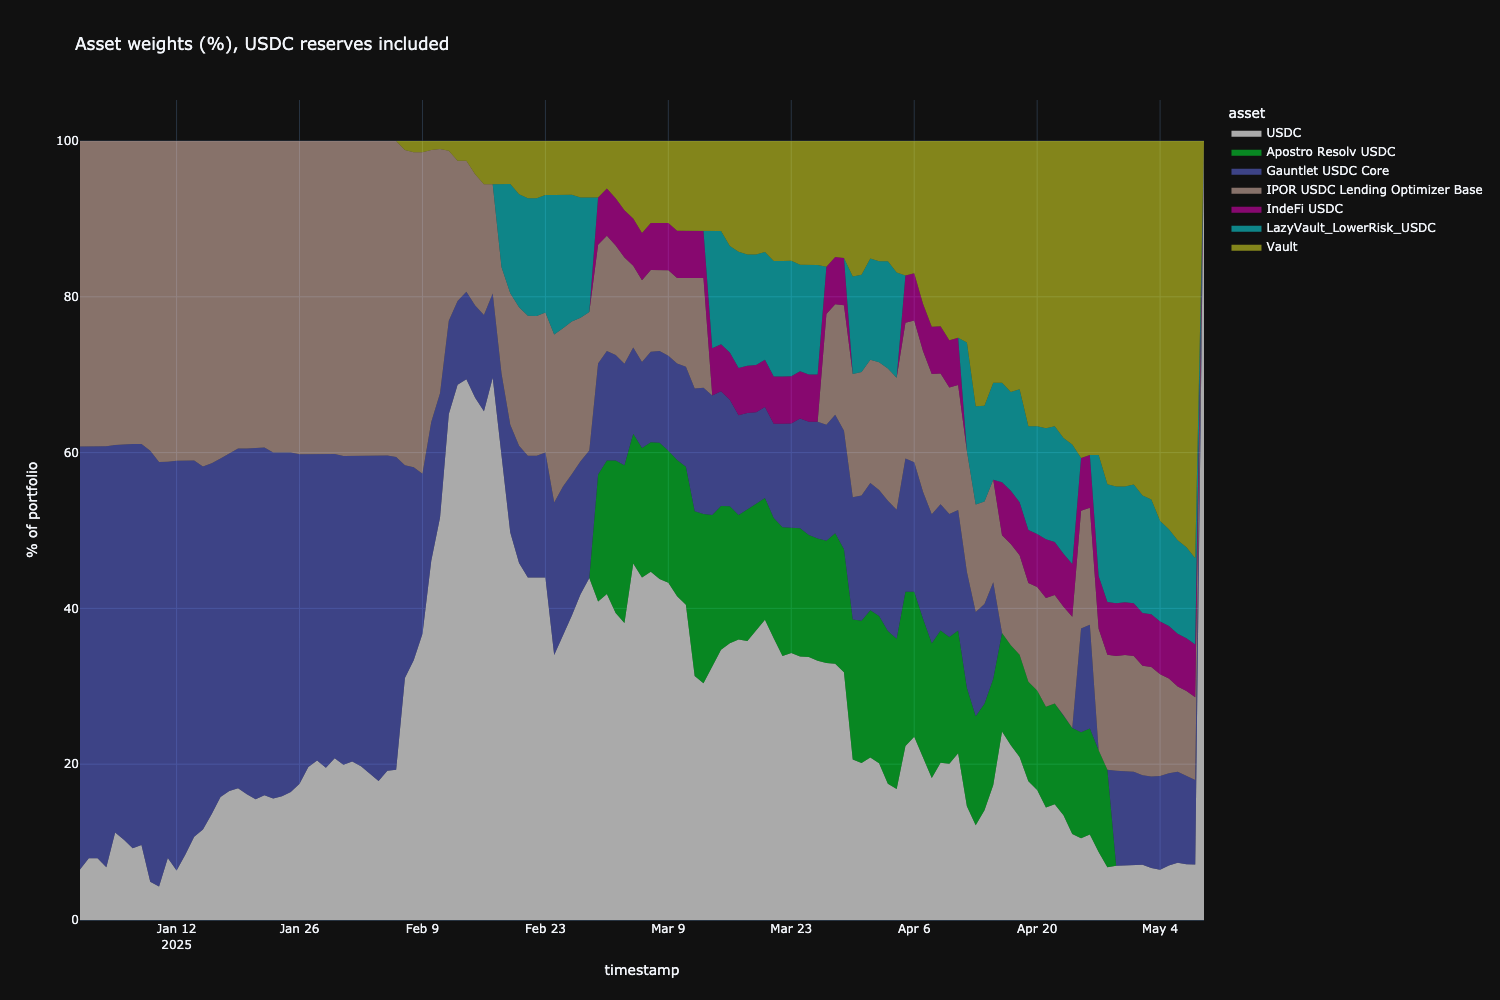

In [13]:

fig = visualise_weights(
    weights_series,
    normalised=True,
    include_reserves=True,
)
fig.show()

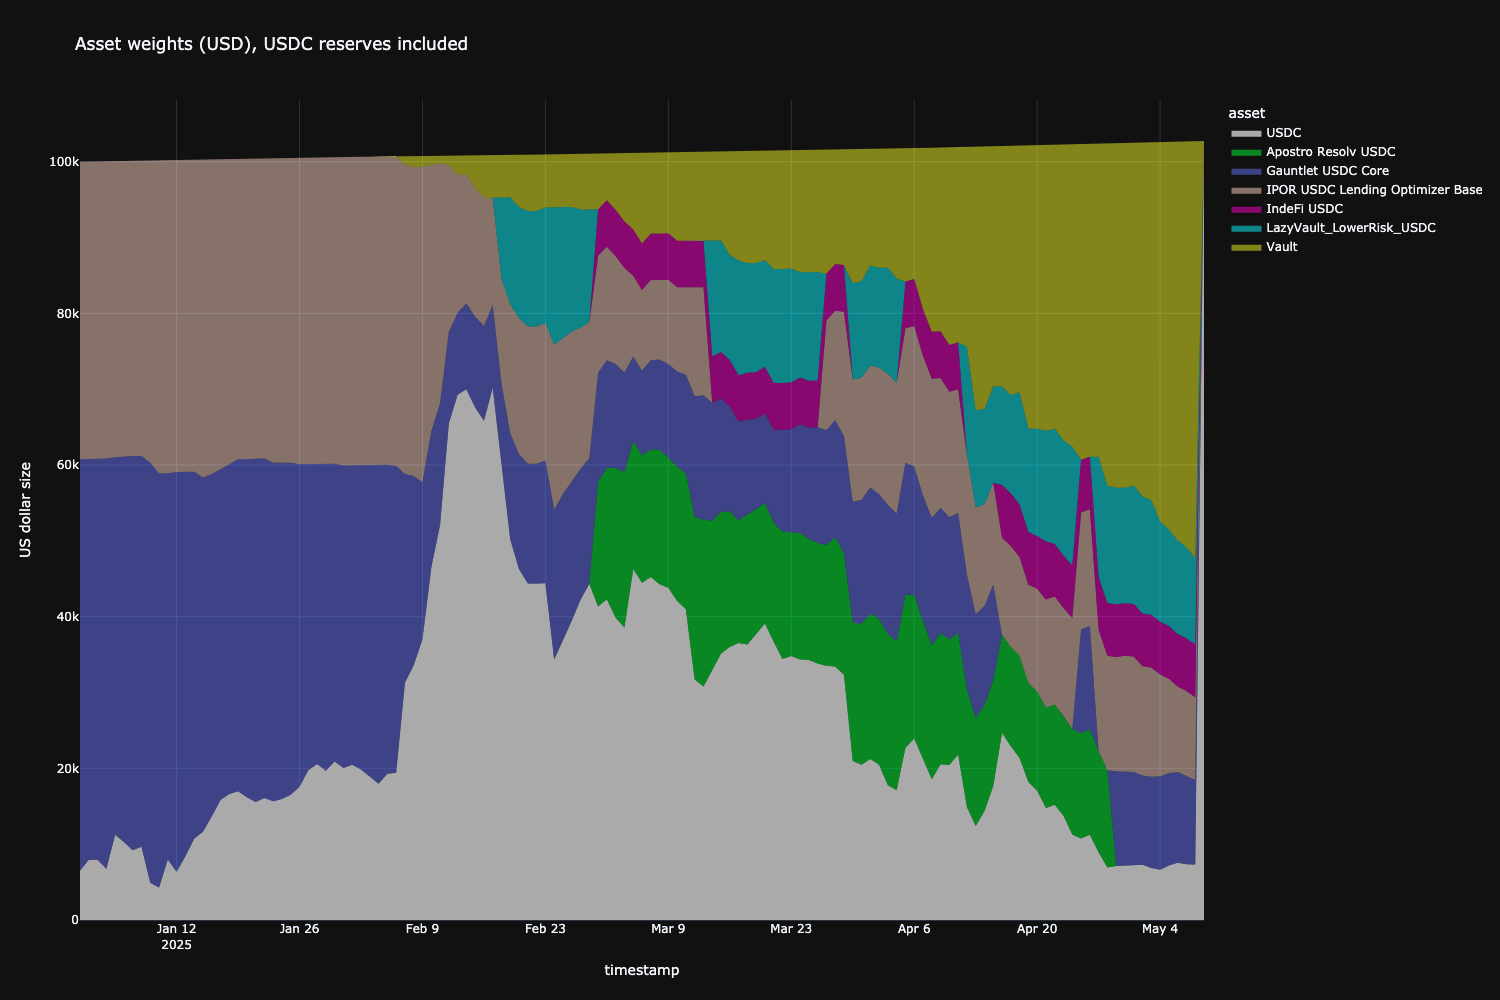

In [14]:
df = weights_series.unstack(level=1)

fig = visualise_weights(
    weights_series,
    normalised=False,
)
fig.show()

## Weight allocation statistics



In [15]:
from tradeexecutor.analysis.weights import calculate_weights_statistics

stats = calculate_weights_statistics(weights_series)
display(stats)


At  \
Name                                                  
Max position (excluding USDC)   2025-01-09 00:00:00   
Min position (excluding USDC)   2025-02-11 00:00:00   
Mean position (excluding USDC)                        
Max position (excluding USDC)   2025-02-09 00:00:00   
Min position (excluding USDC)   2025-02-07 00:00:00   
Mean position (excluding USDC)                        
Max position (including USDC)   2025-05-09 00:00:00   
Min position (including USDC)   2025-02-11 00:00:00   
Mean position (including USDC)                        

                                                            Pair      Value  \
Name                                                                          
Max position (excluding USDC)                 Gauntlet USDC Core  55,390.96   
Min position (excluding USDC)                              Vault   1,042.17   
Mean position (excluding USDC)                                    19,467.95   
Max position (excluding USDC)   IPOR USDC Lending Optimizer Base      65.27   
Min position (excluding USDC)                              Vault       1.69   
Mean position (excluding USDC)                                        25.81   
Max position (including USDC)                               USDC     100.00   
Min position (including USDC)                              Vault       1.03   
Mean position (including USDC)                                        20.64   

                               Unit  
Name                                 
Max position (excluding USDC)   USD  
Min position (excluding USDC)   USD  
Mean position (excluding USDC)  USD  
Max position (excluding USDC)     %  
Min position (excluding USDC)     %  
Mean position (excluding USDC)    %  
Max position (including USDC)     %  
Min position (including USDC)     %  
Mean position (including USDC)    %

# Positions at the end

Some example positions at the end


In [16]:

for p in list(state.portfolio.open_positions.values())[0:10]:
    print(f"Position {p.pair.base.token_symbol}, value {p.get_value()} USD")

Examples of strategy thinking output 

- At the end of strategy
- Reverse order - last timestamp first

In [17]:
messages = state.visualisation.get_messages_tail(2)

table = pd.Series(
    data=list(messages.values()),
    index=list(messages.keys()),
)

df = table.to_frame()

display(df.style.set_properties(**{
    'text-align': 'left',
    'white-space': 'pre-wrap',
}))


# Alpha model diagnostics data

- Dump out alpha model contents from the last cycle

In [18]:
from tradeexecutor.strategy.alpha_model import format_signals

alpha_model = state.visualisation.discardable_data["alpha_model"]

print(f"All signals ({len(df)})")
df = format_signals(alpha_model, signal_type="all")
display(df)

All signals (0)


Empty DataFrame
Columns: []
Index: []

# Trading pair breakdown

- Trade success for each trading pair



In [19]:
from tradeexecutor.analysis.multipair import analyse_multipair
from tradeexecutor.analysis.multipair import format_multipair_summary

multipair_summary = analyse_multipair(state)
format_multipair_summary(multipair_summary, sort_column="Total return %")

# Trading metrics

- Trading cost, etc.

In [20]:
from tradeexecutor.analysis.trade_analyser import build_trade_analysis

analysis = build_trade_analysis(state.portfolio)
summary = analysis.calculate_summary_statistics()
display(summary.to_dataframe())

# Interest accrued

In [21]:
from tradeexecutor.analysis.credit import calculate_credit_metrics

interest_df = calculate_credit_metrics(state)
display(interest_df)

Value
Name                        
Credit position count      0

# Examine single pair

- Show trades taken against a single pair

We have total 90 trades on <Pair ipUSDCfusion-USDC vault at 0x45aa96f0b3188d47a1dafdbefce1db6b37f58216 (0.0000% fee) on exchange ipor>


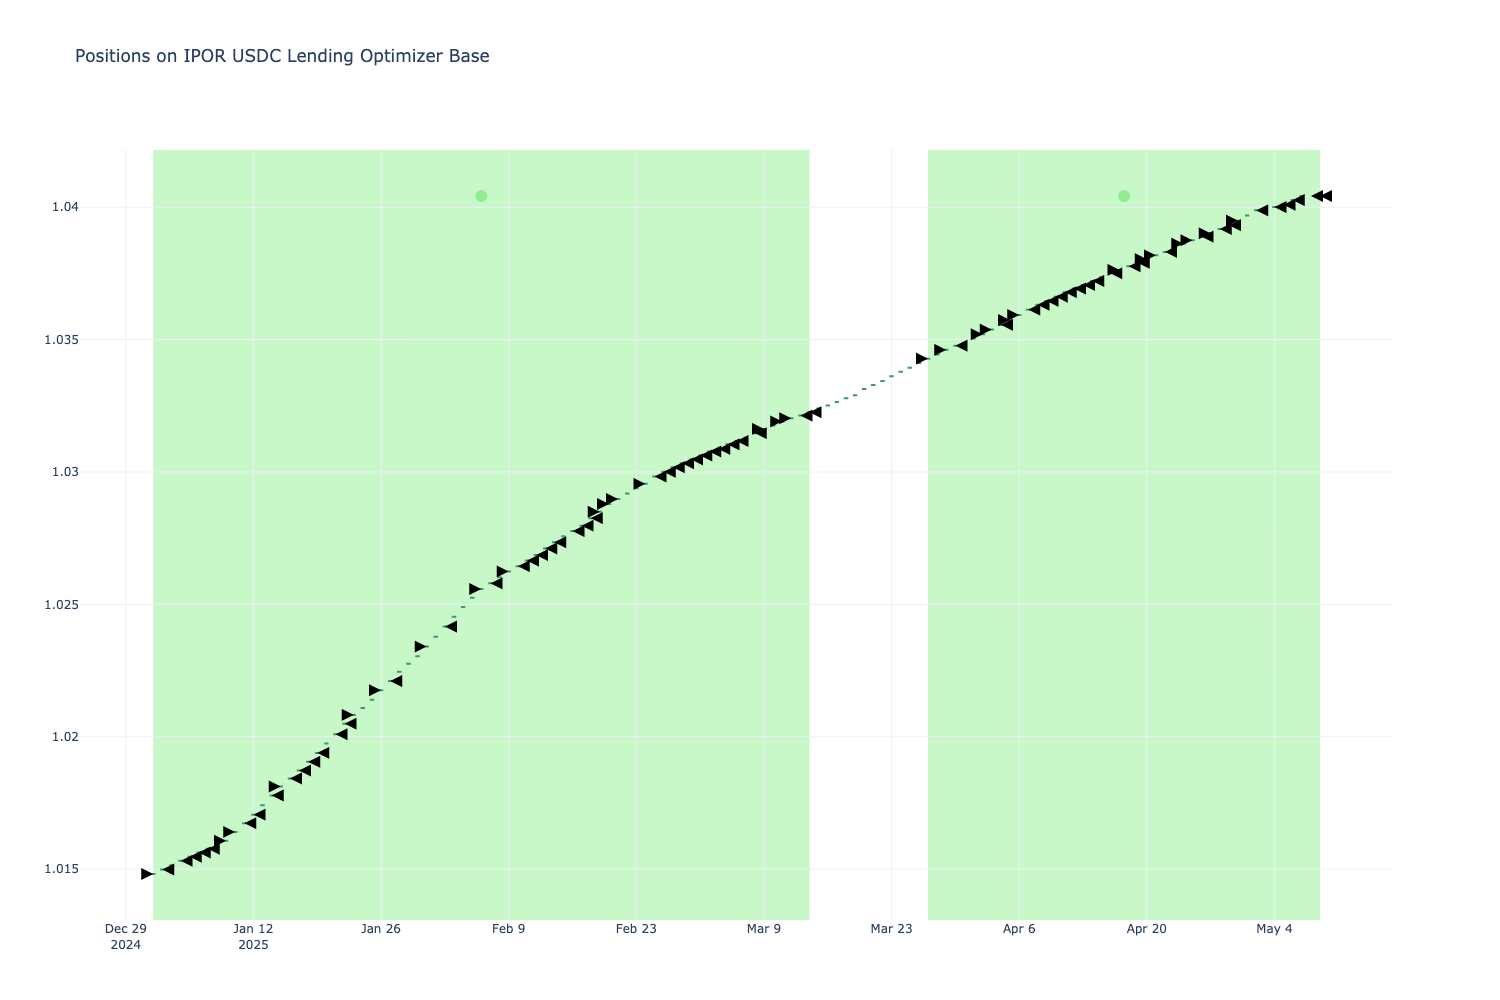

In [22]:
from tradeexecutor.visual.single_pair import visualise_single_pair_positions_with_duration_and_slippage

chain, address = VAULTS[0]
pair = strategy_universe.get_pair_by_address(address)
name = pair.get_vault_name()

all_trades = [t for t in state.portfolio.get_all_trades() if t.pair == pair]
print(f"We have total {len(all_trades)} trades on {pair}")

# start = datetime.datetime(2023, 2, 1)
# end = datetime.datetime(2023, 4, 1)

start = None
end = None

signal = indicator_data.get_indicator_series("signal", pair=pair)

figure = visualise_single_pair_positions_with_duration_and_slippage(
    state=state,
    candles=strategy_universe.data_universe.candles.get_candles_by_pair(pair.internal_id),
    pair_id=pair.internal_id,
    execution_context=notebook_execution_context,
    title=f"Positions on {name}",
    start_at=start,
    end_at=end,
)


figure.show()

## Examine positions

In [23]:
from tradeexecutor.visual.single_pair import display_positions_table
display_positions_table(state, pair, sort_by="PnL USD", ascending=True)

Close Duration     PnL %     PnL USD  Trades
Open                                                        
2025-03-27 2025-05-09  43 days  0.401648   90.548633      36
2025-01-01 2025-03-14  72 days  0.993781  558.676239      54